In [1]:
import pandas as pd
import numpy as np

# Hela ML libraries 
from hela import hmm
import hela.generation.hmm as hmm_gen

# Viz libraries
import altair as alt
import hela.visualization.hmm as hmmplot 
import matplotlib.pyplot as plt
from hela.visualization.hmm import TU_COLORS
%matplotlib inline

# Utility Libraries
from datetime import datetime
from scipy.special import logsumexp
from scipy import stats
import itertools
from IPython.display import Image
import time

### Generative Model

In [2]:
gen = hmm_gen.FactoredHMMGenerativeModel(
                                     ns_hidden_states =[2,3],
                                     n_gaussian_features =2,
                                     n_categorical_features = 2)

factored_hidden_states = gen.generate_hidden_state_sequence(n_observations = 200)

In [3]:
data = gen.generate_observations(factored_hidden_states)
fhmm_training_spec = hmm_gen.data_to_fhmm_training_spec(factored_hidden_states, 
                                   gen.ns_hidden_states, 
                                   data,
                                   categorical_features = list(gen.categorical_values.columns), 
                                   gaussian_features = list(gen.gaussian_values.columns)
                                                       )

fhmm_config = hmm.FactoredHMMConfiguration.from_spec(fhmm_training_spec)
untrained_fhmm_model = fhmm_config.to_model()

### Distributed Gibbs Model Training

In [4]:
distributed_gibbs_alg = untrained_fhmm_model.load_learning_interface()
start_distributed_train = time.time()
distributed_gibbs_model = distributed_gibbs_alg.run(data=data,
                                                    method='gibbs',
                                                    training_iterations=10,
                                                    gibbs_iterations = 10,
                                                    burn_down_period = 5, 
                                                    distributed=True, 
                                                    n_workers = 2)

distributed_train_time = time.time() - start_distributed_train

### Gibbs Model Training

In [5]:
gibbs_alg = untrained_fhmm_model.load_learning_interface()
start_train = time.time()
gibbs_model = gibbs_alg.run(data=data,
                            method='gibbs',
                            training_iterations=10,
                            gibbs_iterations = 10,
                            burn_down_period = 5)
train_time = time.time() - start_train

In [6]:
print("Time for training using Dask: {}".format(distributed_train_time))
print("Time for training: {}".format(train_time))

Time for training using Dask: 140.95509457588196
Time for training: 218.14477682113647


### Distributed Gibbs Inference

In [7]:
inf = distributed_gibbs_model.load_inference_interface()
start_distributed_inference = time.time()
Gamma, Xi, hidden_state_vector_df_distributed = inf.distributed_gibbs_sampling(data,
                                                                               iterations = 50,
                                                                               burn_down_period=0,
                                                                               n_workers = 2)
distributed_inference_time = time.time() - start_distributed_inference


/opt/conda/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


### Gibbs Inference

In [9]:
inf = gibbs_model.load_inference_interface()
start_inference = time.time()
Gamma, Xi, hidden_state_vector_df = inf.gibbs_sampling(data,
                                                       iterations = 50,
                                                       burn_down_period=0)
inference_time = time.time() - start_inference

In [10]:
print("Time for inference using Dask: {}".format(distributed_inference_time))
print("Time for inference: {}".format(inference_time))

Time for inference using Dask: 55.067360401153564
Time for inference: 122.29951000213623


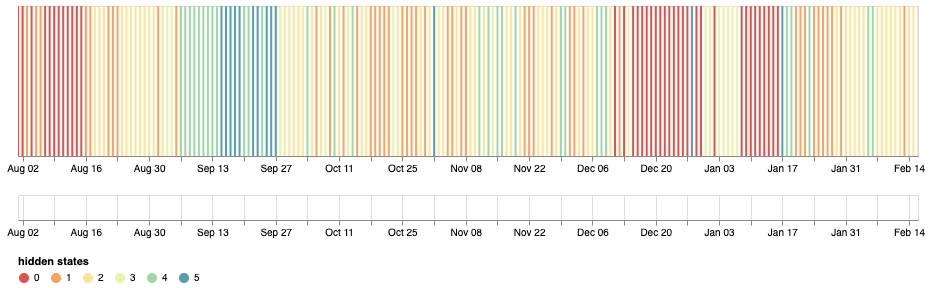

In [11]:
flattened_pred_states = gen.flatten_hidden_state_sequence(hidden_state_vector_df_distributed)
hmmplot.draw_states(flattened_pred_states, hide_brush=False)

In [14]:
p_any = np.sum(np.any(np.array(hidden_state_vector_df_distributed) == np.array(factored_hidden_states), axis = 1)) / data.shape[0]
p_all = np.sum(np.all(np.array(hidden_state_vector_df_distributed) == np.array(factored_hidden_states), axis = 1)) / data.shape[0]

print("{}% of the time distributed Gibbs returned the correct hidden state for at least one system.".format(int(p_any *100)))
print("")
print("{}% of the time distributed Gibbs returned the correct hidden state for every system.".format(int(p_all *100)))

96% of the time distributed Gibbs returned the correct hidden state for at least one system.

45% of the time distributed Gibbs returned the correct hidden state for every system.


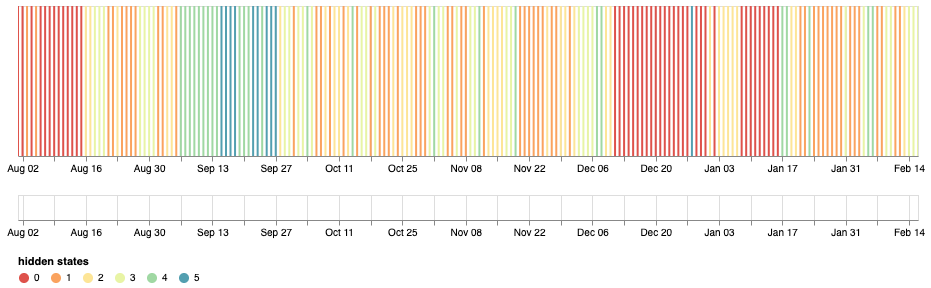

In [13]:
flattened_pred_states = gen.flatten_hidden_state_sequence(hidden_state_vector_df)
hmmplot.draw_states(flattened_pred_states, hide_brush=False)

In [15]:
p_any = np.sum(np.any(np.array(hidden_state_vector_df) == np.array(factored_hidden_states), axis = 1)) / data.shape[0]
p_all = np.sum(np.all(np.array(hidden_state_vector_df) == np.array(factored_hidden_states), axis = 1)) / data.shape[0]

print("{}% of the time Gibbs returned the correct hidden state for at least one system.".format(int(p_any *100)))
print("")
print("{}% of the time Gibbs returned the correct hidden state for every system.".format(int(p_all *100)))

86% of the time Gibbs returned the correct hidden state for at least one system.

31% of the time Gibbs returned the correct hidden state for every system.
